# Wednesday 22 Jan - Quality assessment


In [ ]:
import pandas as pd
import seaborn as sns

In [ ]:
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)

Load our cleaned DataFrames

In [ ]:
# orders_cl.csv
url = "https://drive.google.com/file/d/1Tla62vfu__kCqvgypZyVt2S9VuC016yH/view?usp=sharing"
path = "https://drive.google.com/uc?export=download&id="+url.split("/")[-2]
orders_cl = pd.read_csv(path)

# orderlines_cl.csv
url = "https://drive.google.com/file/d/1OhtkQS2fwOYdzfd-qPh7im35iLc-L9TA/view?usp=sharing"
path = "https://drive.google.com/uc?export=download&id="+url.split("/")[-2]
orderlines_cl = pd.read_csv(path)

# products_cl.csv
url = "https://drive.google.com/file/d/1s7Lai4NSlsYjGEPg1QSOUJobNYVsZBOJ/view?usp=sharing"
path = "https://drive.google.com/uc?export=download&id="+url.split("/")[-2]
products_cl = pd.read_csv(path)

Let's create a copy of our DataFrames, to make sure any of our changes won't affect the original DataFrame. We'll also change the DataFrames from `_cl` to `_qu`, so we can distinguish between the data that has been cleaned, and that which has been quality controlled.

In [ ]:
orders_qu = orders_cl.copy()
orderlines_qu = orderlines_cl.copy()
products_qu = products_cl.copy()

In [ ]:
products_cl.loc[products_cl["type"].isna()]

,sku,name,desc,price,in_stock,type
146,SAN0017,SanDisk Cruzer Edge USB 2.0 Flash Drive 16GB,Pendrive USB 2.0 Mac and PC.,8.00,0,NaN
362,SAN0026,SanDisk Extreme Cruzer 16GB USB 3.0 Flash Drive,USB 3.0 flash drive 16GB USB Mac and PC.,22.00,0,NaN
579,APP0675,Apple iPhone 5S 32GB Space Gray,New Free iPhone 5S 32GB (ME435Y / A).,559.00,0,NaN
956,APP0823,Apple iPhone 6 16GB Silver,New iPhone 6 16GB Free (MG482QL / A).,639.00,0,NaN
961,APP0829,Apple iPhone 6 Plus 16GB Silver,New iPhone 6 Plus 16G Free (MGA92QL / A).,749.00,0,NaN
962,APP0822,Apple iPhone 6 16GB Space Gray,New iPhone 6 16GB Free (MG472QL / A).,639.00,0,NaN
963,APP0825,Apple iPhone 6 64GB Space Gray,New iPhone 6 64GB Free (MG4F2QL / A).,749.00,0,NaN
964,APP0826,Apple iPhone 6 64GB Silver,New iPhone 6 64GB Free (MG4H2QL / A).,749.00,0,NaN
965,APP0828,Apple iPhone 6 Plus 16GB Space Gray,New 16GB iPhone 6 Plus Free (MGA82QL / A).,749.00,0,NaN
1042,APP0856,Apple iPhone 6 128GB Gold,New Free iPhone 6 128GB (MG4E2QL / A).,899.00,0,NaN


## 1.&nbsp; Define Pandas display format

In [ ]:
pd.set_option("display.float_format", lambda x: "%.2f" % x)
pd.set_option("display.max_rows", 1000)

## 2.&nbsp; Exclude unwanted orders

### `orders` - Keep only orders with the state you want to work with
No `shopping cart`, `cancelled` etc...

In [ ]:
orders_qu.head()

,order_id,created_date,total_paid,state
0,241319,2017-01-02 13:35:40,44.99,Cancelled
1,241423,2017-11-06 13:10:02,136.15,Completed
2,242832,2017-12-31 17:40:03,15.76,Completed
3,243330,2017-02-16 10:59:38,84.98,Completed
4,243784,2017-11-24 13:35:19,157.86,Cancelled


Let's look at the make up of `state`.

In [ ]:
orders_qu.state.value_counts()

,count
state,
Shopping Basket,117809
Completed,46605
Place Order,40883
Pending,14374
Cancelled,7233


Seems like an overwhelming amount of the orders are left in the shopping basket - something we'll have to analyse another time. For this task we're interested in only `completed` orders, so let's filter our DataFrame.

In [ ]:
# keep only completed orders
orders_qu = orders_qu.loc[orders_qu.state == "Completed", :]

In [ ]:
orders_qu.shape

(46605, 4)

### Keep only the orders that are present in both `orders` and `orderlines`

Let's begin by looking if there's a big difference between the amount of orders present in `orders` and `orderlines`.

In [ ]:
orders_qu.order_id.nunique()

46605

In [ ]:
orderlines_qu.id_order.nunique()

170213

What a huge difference! We want to make sure that every order_id in `orders` also exists in `orderlines` and vice versa.

Hence we'll perform an inner merge on the two tables using the `order_id` & `id_order`. This will then keep only the `order_id`'s that are present in both tables, which will then help us filter our `_qu` DataFrames once again.

In [ ]:
orders_orderlines = orders_qu.merge(orderlines_qu, how="inner", left_on="order_id", right_on="id_order")

In [ ]:
# order_ids that are in both tables
order_ids = orders_orderlines["order_id"].unique()

In [ ]:
order_ids

array([241423, 242832, 243330, ..., 527074, 527096, 527112])

In [ ]:
# keep those ids in orders
orders_qu = orders_qu.loc[orders_qu["order_id"].isin(order_ids), :]

# keep those ids in orderlines
orderlines_qu = orderlines_qu.loc[orderlines_qu["id_order"].isin(order_ids), :]

Let's have a quick check to make sure we're filtering both DataFrames the same. They should both contain the same number of unique `order_id`'s.

In [ ]:
orders_qu["order_id"].nunique(), orderlines_qu["id_order"].nunique()

(43064, 43064)

## 3.&nbsp; Exclude orders with unknown products

Let's start by investigating `orderlines` and `products`. We want to make sure that every product in `orderlines` has a matching entry in `products`. All orders with a missing product need to be removed from both `orderlines` and `orders`.

A left-join can help us here:

Joining `orderlines` left on `products` will keep all orderlines, and add the information of `products` on the matching skus. If an sku has been sold in `orderlines`, but the sku does not have an entry in `products` then the product_name will be empty.

In [ ]:
orderlines_products = orderlines_qu.merge(products_qu, how="left", on = "sku")[["id_order","sku","name" ]]
orderlines_products.sample(10)

,id_order,sku,name
11396,350915,OWC0035-2,Mac memory OWC 8GB (2x4GB) SO-DIMM DDR3 1066MHZ
33336,435710,APP1922,AirPods Apple Bluetooth Headset for iPhone iPad iPod and Apple Watch
24422,401974,APP1966,Apple iPhone 32GB Silver
46902,486355,SAT0073,Satechi Multiport Adapter HDMI Type-C USB 3 port Ethernet 4K reader SD and micro SD V2 Gray Space
33049,434566,CRU0026-2,Crucial memory Mac 16GB (2x8GB) SO-DIMM DDR3 1333MHz
2348,307158,APP1048,Apple extension cable for power adapter
32244,427253,CRU0015-2,NaN
54644,515632,OWC0013,OWC Kit of 5 tools for Mac and PC
11230,350242,NTE0054,NewerTech NuGuard KX iPad Air Case Black
50710,502555,JBL0123,JBL T450 Bluetooth BT Headset White


In [ ]:
orderlines_qu

,id,id_order,product_id,product_quantity,sku,unit_price,date
6,1119116,299545,0,1,OWC0100,47.49,2017-01-01 01:46:16
7,1119119,299546,0,1,IOT0014,18.99,2017-01-01 01:50:34
8,1119120,295347,0,1,APP0700,72.19,2017-01-01 01:54:11
15,1119134,299556,0,1,CRU0039-A,60.90,2017-01-01 02:20:14
21,1119145,299561,0,1,PEB0015,142.49,2017-01-01 02:38:50
...,...,...,...,...,...,...,...
215889,1649474,525664,0,1,TUC0207,16.52,2018-03-14 11:45:05
215906,1649512,527070,0,2,APP0698,9.99,2018-03-14 11:49:01
215911,1649522,527074,0,2,APP0698,9.99,2018-03-14 11:49:36
215932,1649565,527096,0,3,APP0698,9.99,2018-03-14 11:54:35


We can count how many missing products we have.

In [ ]:
orderlines_products.name.isna().value_counts()

,count
name,
False,55320
True,1394


Looks like the vast majority of products are known.

We can't simply delete the rows containing unknown products. We need to remove the entirety of any order that contains an unknown product to keep a consistent and coherent dataset.

In [ ]:
orders_to_delete = orderlines_products.loc[orderlines_products.name.isna(), "id_order"].unique()
orders_to_delete

array([299638, 299706, 299712, ..., 526106, 526122, 526363])

Keep only orders in `orders` and `orderlines`, that are not in this list of corrupted orders.

In [ ]:
orders_qu = orders_qu.loc[~orders_qu.order_id.isin(orders_to_delete),:]

In [ ]:
orderlines_qu = orderlines_qu.loc[~orderlines_qu.id_order.isin(orders_to_delete),:]

Let's have a quick check to make sure we're filtering both DataFrames the same. They should both contain the same number of unique `order_id`'s.

In [ ]:
orders_qu["order_id"].nunique(), orderlines_qu["id_order"].nunique()

(41701, 41701)

## 4.&nbsp; Explore the revenue from different tables

In a consistent and coherent dataset the value of an order should roughly match the sum of all items bought on that order. Let's investigate...

In [ ]:
orderlines_qu_copy = orderlines_qu.copy()

In [ ]:
orders_qu_copy = orders_qu.copy()

#### Step 1:
Create the `unit_price_total` as `orderlines.unit_price` * `orderlines.product_quantity`

In [ ]:
orderlines_qu_copy["unit_price_total"] = orderlines_qu_copy["product_quantity"] * orderlines_qu_copy["unit_price"]

In [ ]:
orderlines_qu_copy.tail(10)

,id,id_order,product_id,product_quantity,sku,unit_price,date,unit_price_total
215873,1649440,527035,0,1,APP0498,23.00,2018-03-14 11:41:55,23.00
215874,1649441,527034,0,1,APP0927,13.99,2018-03-14 11:42:01,13.99
215876,1649446,527042,0,1,APP0927,13.99,2018-03-14 11:42:38,13.99
215877,1649447,527035,0,1,APP0698,9.99,2018-03-14 11:42:41,9.99
215886,1649468,525664,0,1,TUC0336,7.93,2018-03-14 11:43:59,7.93
215889,1649474,525664,0,1,TUC0207,16.52,2018-03-14 11:45:05,16.52
215906,1649512,527070,0,2,APP0698,9.99,2018-03-14 11:49:01,19.98
215911,1649522,527074,0,2,APP0698,9.99,2018-03-14 11:49:36,19.98
215932,1649565,527096,0,3,APP0698,9.99,2018-03-14 11:54:35,29.97
215949,1649593,527112,0,1,APP0698,9.99,2018-03-14 11:58:13,9.99


#### Step 2:
Group by `id_order`, summarising by the sum of `unit_price_total`

In [ ]:
orderlines_order_ids = orderlines_qu_copy.groupby("id_order", as_index=False)["unit_price_total"].sum()
# as_index=False changes the return so that the groupedby column remains a column (not the index)

In [ ]:
orderlines_order_ids

,id_order,unit_price_total
0,241423,129.16
1,242832,10.77
2,243330,77.99
3,245275,149.00
4,245595,105.98
...,...,...
41696,527042,13.99
41697,527070,19.98
41698,527074,19.98
41699,527096,29.97


### What is the average difference between `total_paid` and `unit_price_total`?

Let's merge our grouped `orderlines` table with the `orders` table, so we can calculate the differences in prices.

In [ ]:
diff_df = orders_qu_copy.merge(orderlines_order_ids, left_on="order_id", right_on="id_order")

In [ ]:
diff_df["difference"] = diff_df["total_paid"] - diff_df["unit_price_total"]
diff_df.head(10)

,order_id,created_date,total_paid,state,id_order,unit_price_total,difference
0,241423,2017-11-06 13:10:02,136.15,Completed,241423,129.16,6.99
1,242832,2017-12-31 17:40:03,15.76,Completed,242832,10.77,4.99
2,243330,2017-02-16 10:59:38,84.98,Completed,243330,77.99,6.99
3,245275,2017-06-28 11:35:37,149.00,Completed,245275,149.00,0.00
4,245595,2017-01-21 12:52:47,112.97,Completed,245595,105.98,6.99
5,246405,2017-11-24 10:01:27,407.96,Completed,246405,275.75,132.21
6,247524,2018-01-09 14:21:34,167.98,Completed,247524,162.99,4.99
7,247643,2017-05-26 11:50:35,153.54,Completed,247643,153.54,0.00
8,250275,2017-11-19 22:34:54,54.99,Completed,250275,51.00,3.99
9,251302,2017-05-10 12:27:33,140.99,Completed,251302,140.99,0.00


Now that we know the difference for each order, we can compute the average.

In [ ]:
diff_df.difference.mean().round(2)

4.47

### What is the distribution of these differences?

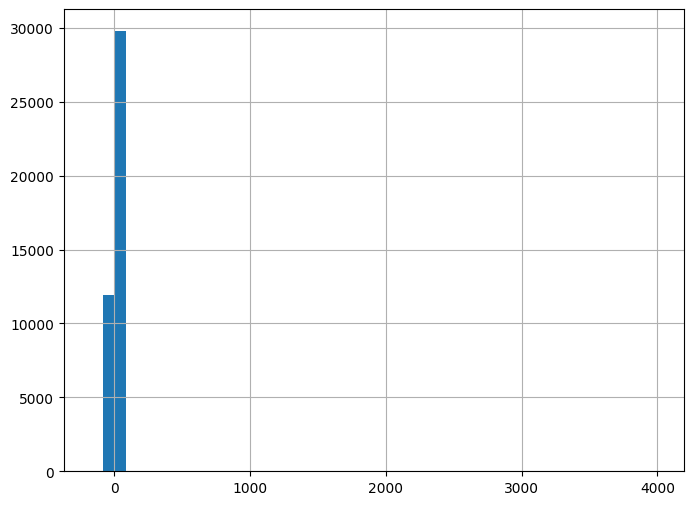

In [ ]:
diff_df.difference.hist(bins= 50, figsize=(8,6));

Looking at the spread of the data above, some of the difference must be due to corruption. Let's use `.describe()` to investigate the distribution further.

In [ ]:
diff_df.difference.describe()

,difference
count,41701.00
mean,4.47
std,26.05
min,-165.00
25%,0.00
50%,4.99
75%,6.99
max,3984.99


We can see from the our quartiles (0.00, 4.99, 6.99) that most of our data fits an expected pattern - free, 4.99, and 6.99 all seem like reasonable prices to assume as postage. However, look at the min and the max values, -165.00 and 3984.99, this can only occur due to corrupted data.

### Can all the differences be explained by shipping costs? If not, what are other plausible explanations?

What reasons have you come up with to explain the difference?

### If there are differences that you can’t explain: what should you do with these orders?
There's a rule of thumb, that anything:
+ lower than the 25% quartile - (1.5 x interquartile range), or
+ higher than the 75% quartile + (1.5 x interquartile range)

is an outlier. Let's use this rule to try and exclude any corrupted data.

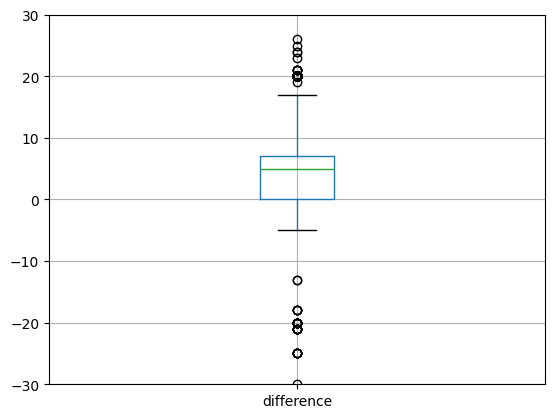

In [ ]:
# We know this rule from the boxplot
import matplotlib.pyplot as plt

ax = diff_df.boxplot("difference");
ax.set_ylim(-30, +30)
plt.show()

In [ ]:
# calculate the quartiles
Q1 = diff_df["difference"].quantile(0.25)
Q3 = diff_df["difference"].quantile(0.75)

Q1, Q3

(0.0, 6.989999999999981)

In [ ]:
# calculate the interquartile range
IQR = Q3-Q1
IQR

6.989999999999981

In [ ]:
# lower boundary
Q1 - 1.5*IQR

-10.484999999999971

In [ ]:
# upper boundary
Q3 + 1.5*IQR

17.47499999999995

In [ ]:
# filter the DataFrame to include only "non-outliers"
diff_no_outliers_df = diff_df.loc[
    (diff_df["difference"] >= (Q1 - 1.5*IQR))
    &
    (diff_df["difference"] <= (Q3 + 1.5*IQR))
    ,
    :]

Let's look at the distribution again to see the effect of removing the outliers.

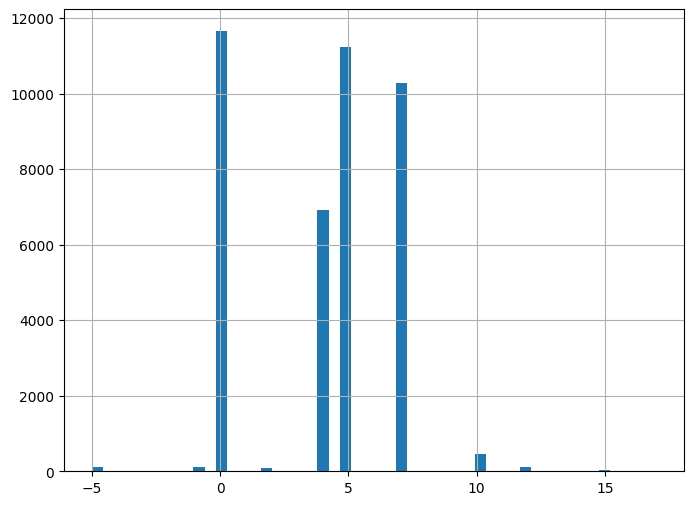

In [ ]:
diff_no_outliers_df.difference.hist(bins= 50, figsize=(8,6));

<Axes: >

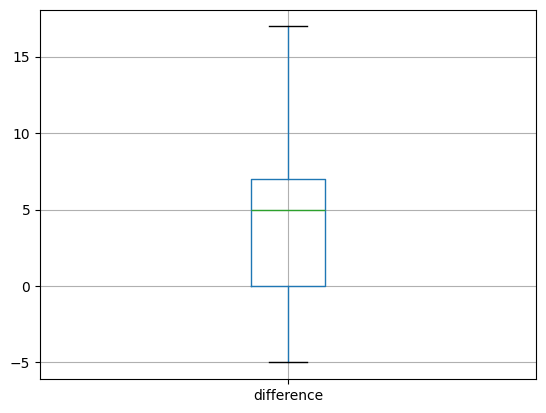

In [ ]:
diff_no_outliers_df.boxplot("difference")

In [ ]:
diff_no_outliers_df

,order_id,created_date,total_paid,state,id_order,unit_price_total,difference
0,241423,2017-11-06 13:10:02,136.15,Completed,241423,129.16,6.99
1,242832,2017-12-31 17:40:03,15.76,Completed,242832,10.77,4.99
2,243330,2017-02-16 10:59:38,84.98,Completed,243330,77.99,6.99
3,245275,2017-06-28 11:35:37,149.00,Completed,245275,149.00,0.00
4,245595,2017-01-21 12:52:47,112.97,Completed,245595,105.98,6.99
...,...,...,...,...,...,...,...
41696,527042,2018-03-14 11:47:50,18.98,Completed,527042,13.99,4.99
41697,527070,2018-03-14 11:50:48,24.97,Completed,527070,19.98,4.99
41698,527074,2018-03-14 11:51:42,24.97,Completed,527074,19.98,4.99
41699,527096,2018-03-14 11:58:40,34.96,Completed,527096,29.97,4.99


This looks much more like what we would expect: a small difference, but nothing extreme.

Now we need to remove these orders with extreme differences from our `orders_lines_merged` DataFrame.

In [ ]:
normal_diff_list = diff_no_outliers_df["order_id"]

In [ ]:
orders_qu = orders_qu.loc[orders_qu["order_id"].isin(normal_diff_list), :]
orderlines_qu = orderlines_qu.loc[orderlines_qu["id_order"].isin(normal_diff_list), :]

In [ ]:
orders_qu["order_id"].nunique(), orderlines_qu["id_order"].nunique()

(40985, 40985)

# Thursday 23 Jan - Analysis of discounts

## 1. How many products are being discounted?

In [ ]:
# product_id irritated me. Every cell contains '0' so has no descriptive information for us.
orderlines_qu = orderlines_qu.drop(axis=1, labels=["product_id"])

In [ ]:
orderlines_2_products_qu = orderlines_qu.merge(right=products_qu, left_on="sku", right_on="sku")

In [ ]:
# Filter for products where the unit price of orderline differs from original product price
orderlines_2_products_qu = orderlines_2_products_qu.loc[orderlines_2_products_qu["unit_price"] != orderlines_2_products_qu["price"]]

# Calc discount
orderlines_2_products_qu["discount"] = orderlines_2_products_qu["price"] - orderlines_2_products_qu["unit_price"]

# Group by product sku - so we have one unique product per row
df_avg_discounts_per_product = orderlines_2_products_qu.groupby("sku").mean("discount")

# Count
df_avg_discounts_per_product.count()


,0
id,4982
id_order,4982
product_quantity,4982
unit_price,4982
price,4982
in_stock,4982
discount,4982


Meaning now that the number of 5028 is the count of different products a discount was granted on.

## How big are the offered discounts as a percentage of the product prices?

In [ ]:
df_avg_discounts_per_product

,id,id_order,product_quantity,unit_price,price,in_stock,discount
sku,,,,,,,
8MO0001-A,1365769.00,406520.00,1.00,12.96,35.00,0.00,22.04
8MO0003-A,1640610.00,523426.00,1.00,12.85,35.00,0.00,22.15
8MO0007,1269903.57,365413.71,1.00,22.28,35.00,0.00,12.72
8MO0008,1283089.00,372645.50,1.10,21.59,35.00,0.00,13.41
8MO0009,1434884.80,436605.00,1.00,17.47,35.00,1.00,17.53
...,...,...,...,...,...,...,...
ZAG0040,1627724.00,517695.00,1.00,26.99,39.99,1.00,13.00
ZAG0041,1641150.00,523690.00,1.00,19.99,29.99,1.00,10.00
ZAG0042,1641159.00,523690.00,1.00,19.99,29.99,1.00,10.00


In [ ]:
df_avg_discounts_per_product["discount_perc"] = df_avg_discounts_per_product["discount"] / df_avg_discounts_per_product["price"] * 100

df_avg_discounts_per_product = df_avg_discounts_per_product.reset_index()

df_avg_discounts_per_product = df_avg_discounts_per_product.loc[df_avg_discounts_per_product["discount_perc"] >= 0]

df_avg_discounts_per_product = df_avg_discounts_per_product.sort_values(by="discount_perc", ascending=False)




df_avg_discounts_per_product

,sku,id,id_order,product_quantity,unit_price,price,in_stock,discount,discount_perc
2544,MOP0107,1616069.88,501896.79,1.21,7.16,69.95,0.00,62.79,89.77
2545,MOP0108,1619698.50,513548.20,1.20,7.39,69.95,0.00,62.56,89.44
2543,MOP0106,1615875.48,511392.81,1.10,9.51,89.95,0.00,80.44,89.42
2542,MOP0105,1616132.00,512588.96,1.04,9.80,89.95,0.00,80.15,89.10
2546,MOP0109,1616162.48,512503.40,1.16,8.03,69.95,0.00,61.92,88.52
...,...,...,...,...,...,...,...,...,...
1098,BOO0090,1419167.67,429828.00,1.00,49.99,50.00,1.00,0.01,0.02
4326,SYN0107,1284115.00,373161.50,1.00,544.90,544.99,0.00,0.09,0.02
1982,KAI0007,1240607.00,352190.00,1.00,88.99,89.00,0.00,0.01,0.01
4308,SXA0007,1284906.00,373806.00,1.00,209.99,210.00,0.00,0.01,0.00


Text(0.5, 0, 'Discount percentage interval')

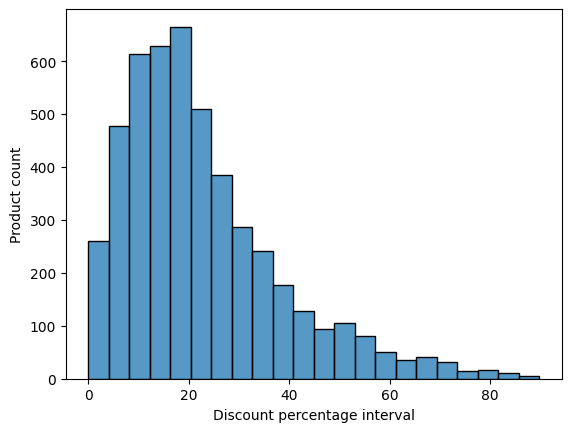

In [ ]:

plot = sns.histplot(data=df_avg_discounts_per_product, x="discount_perc", bins=22)
plot.set_ylabel("Product count")
plot.set_xlabel("Discount percentage interval")



## Most expensive products in every discount interval

In [ ]:

def take_n_most_expensive_in_discountperc_bin(discount_low_border, discount_high_border):
  result_df = df_avg_discounts_per_product.loc[df_avg_discounts_per_product["discount_perc"].between(discount_low_border, discount_high_border), ["sku", "unit_price", "price", "discount", "discount_perc"]]
  result_df["discount_bin"] = f"{discount_low_border} < x < {discount_high_border}"
  result_df["total_product_count"] = df_avg_discounts_per_product.loc[df_avg_discounts_per_product["discount_perc"].between(discount_low_border, discount_high_border)].count()
  return result_df.nlargest(2, columns="price")

discount_bins_df = take_n_most_expensive_in_discountperc_bin(0, 4)
discount_bins_df = pd.concat([discount_bins_df, take_n_most_expensive_in_discountperc_bin(5, 9)])
discount_bins_df = pd.concat([discount_bins_df, take_n_most_expensive_in_discountperc_bin(10, 14)])
discount_bins_df = pd.concat([discount_bins_df, take_n_most_expensive_in_discountperc_bin(15, 19)])
discount_bins_df = pd.concat([discount_bins_df, take_n_most_expensive_in_discountperc_bin(20, 24)])
discount_bins_df = pd.concat([discount_bins_df, take_n_most_expensive_in_discountperc_bin(25, 29)])
discount_bins_df = pd.concat([discount_bins_df, take_n_most_expensive_in_discountperc_bin(30, 34)])
discount_bins_df = pd.concat([discount_bins_df, take_n_most_expensive_in_discountperc_bin(35, 39)])
discount_bins_df = pd.concat([discount_bins_df, take_n_most_expensive_in_discountperc_bin(40, 44)])
discount_bins_df = pd.concat([discount_bins_df, take_n_most_expensive_in_discountperc_bin(45, 49)])
discount_bins_df = pd.concat([discount_bins_df, take_n_most_expensive_in_discountperc_bin(50, 54)])
discount_bins_df = pd.concat([discount_bins_df, take_n_most_expensive_in_discountperc_bin(55, 59)])
discount_bins_df = pd.concat([discount_bins_df, take_n_most_expensive_in_discountperc_bin(60, 64)])
discount_bins_df = pd.concat([discount_bins_df, take_n_most_expensive_in_discountperc_bin(65, 69)])
discount_bins_df = pd.concat([discount_bins_df, take_n_most_expensive_in_discountperc_bin(70, 74)])
discount_bins_df = pd.concat([discount_bins_df, take_n_most_expensive_in_discountperc_bin(75, 79)])
discount_bins_df = pd.concat([discount_bins_df, take_n_most_expensive_in_discountperc_bin(80, 84)])
discount_bins_df = pd.concat([discount_bins_df, take_n_most_expensive_in_discountperc_bin(85, 89)])
discount_bins_df = pd.concat([discount_bins_df, take_n_most_expensive_in_discountperc_bin(90, 94)])
discount_bins_df = pd.concat([discount_bins_df, take_n_most_expensive_in_discountperc_bin(95, 100)])

discount_bins_df

,sku,unit_price,price,discount,discount_perc,discount_bin,total_product_count
3440,PAC1431,984.99,1025.20,40.21,3.92,0 < x < 4,NaN
3522,PAC1923,979.99,999.99,20.00,2.00,0 < x < 4,NaN
694,APP2118,999.00,1069.00,70.00,6.55,5 < x < 9,NaN
3437,PAC1417,988.94,1061.89,72.95,6.87,5 < x < 9,NaN
295,AP20458,999.00,1159.00,160.00,13.81,10 < x < 14,NaN
3501,PAC1868,970.67,1110.99,140.32,12.63,10 < x < 14,NaN
3557,PAC2187,976.83,1195.09,218.26,18.26,15 < x < 19,NaN
3465,PAC1519,946.14,1122.99,176.85,15.75,15 < x < 19,NaN
2294,LGE0047,999.00,1299.00,300.00,23.09,20 < x < 24,NaN
3406,PAC1331,992.37,1249.95,257.58,20.61,20 < x < 24,NaN


In [ ]:
discount_bins_df = discount_bins_df.merge(products_qu, left_on="sku", right_on="sku", how="inner")


discount_bins_groupby = discount_bins_df.groupby("discount_bin")["name"].count()
discount_bins_groupby

,name
discount_bin,
0 < x < 4,2
10 < x < 14,2
15 < x < 19,2
20 < x < 24,2
25 < x < 29,2
30 < x < 34,2
35 < x < 39,2
40 < x < 44,2
45 < x < 49,2


# Friday 24 Jan - Building categories

## Preparation of the dataframe (to have the right data to search on)

In [ ]:
# df_avg_discounts_per_product.loc[(df_avg_discounts_per_product["discount_perc"] < 0) & (df_avg_discounts_per_product["sku"].str[:3] != "APP")]

In [ ]:
products_co = products_qu.merge(right=orderlines_products, left_on="sku", right_on="sku", how="inner")
products_co

,sku,name_x,desc,price,in_stock,type,id_order,name_y
0,RAI0007,Silver Rain Design mStand Support,Aluminum support compatible with all MacBook,59.99,1,8696,300551,Silver Rain Design mStand Support
1,RAI0007,Silver Rain Design mStand Support,Aluminum support compatible with all MacBook,59.99,1,8696,310820,Silver Rain Design mStand Support
2,RAI0007,Silver Rain Design mStand Support,Aluminum support compatible with all MacBook,59.99,1,8696,311042,Silver Rain Design mStand Support
3,RAI0007,Silver Rain Design mStand Support,Aluminum support compatible with all MacBook,59.99,1,8696,324568,Silver Rain Design mStand Support
4,RAI0007,Silver Rain Design mStand Support,Aluminum support compatible with all MacBook,59.99,1,8696,327565,Silver Rain Design mStand Support
...,...,...,...,...,...,...,...,...
55315,MMW0015,"My MW Case MacBook Pro 13 ""(Late 2016) Gray",Avoid shock and damage to your MacBook Pro 13-inch end of 2016 thanks to the foam LRPu,29.99,1,13835403,464365,"My MW Case MacBook Pro 13 ""(Late 2016) Gray"
55316,MMW0015,"My MW Case MacBook Pro 13 ""(Late 2016) Gray",Avoid shock and damage to your MacBook Pro 13-inch end of 2016 thanks to the foam LRPu,29.99,1,13835403,475426,"My MW Case MacBook Pro 13 ""(Late 2016) Gray"
55317,MMW0015,"My MW Case MacBook Pro 13 ""(Late 2016) Gray",Avoid shock and damage to your MacBook Pro 13-inch end of 2016 thanks to the foam LRPu,29.99,1,13835403,490325,"My MW Case MacBook Pro 13 ""(Late 2016) Gray"
55318,MMW0015,"My MW Case MacBook Pro 13 ""(Late 2016) Gray",Avoid shock and damage to your MacBook Pro 13-inch end of 2016 thanks to the foam LRPu,29.99,1,13835403,496812,"My MW Case MacBook Pro 13 ""(Late 2016) Gray"


In [ ]:
products_co = products_co.rename(columns={"name_x" : "name"})
products_co

,sku,name,desc,price,in_stock,type,id_order,name_y
0,RAI0007,Silver Rain Design mStand Support,Aluminum support compatible with all MacBook,59.99,1,8696,300551,Silver Rain Design mStand Support
1,RAI0007,Silver Rain Design mStand Support,Aluminum support compatible with all MacBook,59.99,1,8696,310820,Silver Rain Design mStand Support
2,RAI0007,Silver Rain Design mStand Support,Aluminum support compatible with all MacBook,59.99,1,8696,311042,Silver Rain Design mStand Support
3,RAI0007,Silver Rain Design mStand Support,Aluminum support compatible with all MacBook,59.99,1,8696,324568,Silver Rain Design mStand Support
4,RAI0007,Silver Rain Design mStand Support,Aluminum support compatible with all MacBook,59.99,1,8696,327565,Silver Rain Design mStand Support
...,...,...,...,...,...,...,...,...
55315,MMW0015,"My MW Case MacBook Pro 13 ""(Late 2016) Gray",Avoid shock and damage to your MacBook Pro 13-inch end of 2016 thanks to the foam LRPu,29.99,1,13835403,464365,"My MW Case MacBook Pro 13 ""(Late 2016) Gray"
55316,MMW0015,"My MW Case MacBook Pro 13 ""(Late 2016) Gray",Avoid shock and damage to your MacBook Pro 13-inch end of 2016 thanks to the foam LRPu,29.99,1,13835403,475426,"My MW Case MacBook Pro 13 ""(Late 2016) Gray"
55317,MMW0015,"My MW Case MacBook Pro 13 ""(Late 2016) Gray",Avoid shock and damage to your MacBook Pro 13-inch end of 2016 thanks to the foam LRPu,29.99,1,13835403,490325,"My MW Case MacBook Pro 13 ""(Late 2016) Gray"
55318,MMW0015,"My MW Case MacBook Pro 13 ""(Late 2016) Gray",Avoid shock and damage to your MacBook Pro 13-inch end of 2016 thanks to the foam LRPu,29.99,1,13835403,496812,"My MW Case MacBook Pro 13 ""(Late 2016) Gray"


In [ ]:
products_co = products_co.drop("name_y", axis=1)
products_co["category"] = ""
products_co

,sku,name,desc,price,in_stock,type,id_order,category
0,RAI0007,Silver Rain Design mStand Support,Aluminum support compatible with all MacBook,59.99,1,8696,300551,
1,RAI0007,Silver Rain Design mStand Support,Aluminum support compatible with all MacBook,59.99,1,8696,310820,
2,RAI0007,Silver Rain Design mStand Support,Aluminum support compatible with all MacBook,59.99,1,8696,311042,
3,RAI0007,Silver Rain Design mStand Support,Aluminum support compatible with all MacBook,59.99,1,8696,324568,
4,RAI0007,Silver Rain Design mStand Support,Aluminum support compatible with all MacBook,59.99,1,8696,327565,
...,...,...,...,...,...,...,...,...
55315,MMW0015,"My MW Case MacBook Pro 13 ""(Late 2016) Gray",Avoid shock and damage to your MacBook Pro 13-inch end of 2016 thanks to the foam LRPu,29.99,1,13835403,464365,
55316,MMW0015,"My MW Case MacBook Pro 13 ""(Late 2016) Gray",Avoid shock and damage to your MacBook Pro 13-inch end of 2016 thanks to the foam LRPu,29.99,1,13835403,475426,
55317,MMW0015,"My MW Case MacBook Pro 13 ""(Late 2016) Gray",Avoid shock and damage to your MacBook Pro 13-inch end of 2016 thanks to the foam LRPu,29.99,1,13835403,490325,
55318,MMW0015,"My MW Case MacBook Pro 13 ""(Late 2016) Gray",Avoid shock and damage to your MacBook Pro 13-inch end of 2016 thanks to the foam LRPu,29.99,1,13835403,496812,


In [ ]:
products_co["name"] = products_co["name"].str.strip()

## Categorize phones

In [ ]:
#
regex = "^.{0,14}Apple iPhone"

filter = (
    (products_co["category"] == "")
    &
    (
        (products_co["name"].str.contains(regex, regex=True, case=False))
        | (products_co["desc"].str.contains(regex, regex=True, case=False))
    )
)
products_phones_co = products_co.loc[filter]
products_phones_co

skus_phones = products_phones_co.loc[~products_co["name"].str.contains("case", case=False) & ~products_co["desc"].str.contains("case", case=False)].sku

products_co.loc[products_co["sku"].isin(skus_phones), "category"] = "Phones"

In [ ]:
products_co.value_counts("category")

,count
category,
,52973
Phones,2347


## Categorize MacBooks

In [ ]:
filter = (
    products_co["name"].str.contains("^.{0,14}Apple MacBook (Air|Pro)", case=False, regex=True)
  #  & ~products_co["name"].str.contains("charger", case=False)
  #  & ~products_co["name"].str.contains("case", case=False)
  #  & ~products_co["name"].str.contains("support", case=False)
  #  & ~products_co["name"].str.contains("adapter", case=False)
  #  & ~products_co["desc"].str.contains("Keyboard Protector", case=False)
  #  & ~products_co["name"].str.contains("Docking Station", case=False)
)

products_co.loc[filter, "category"] = "MacBooks"

<ipython-input-64-fe7eb7c73b2c>:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  products_co["name"].str.contains("^.{0,14}Apple MacBook (Air|Pro)", case=False, regex=True)


In [ ]:
products_co.value_counts("category")

,count
category,
,52794
Phones,2347
MacBooks,179


In [ ]:
pd.options.display.max_rows = 2000

Show macBooks sorted by name

In [ ]:
filter = (
    products_co["name"].str.contains("^\.{0,7}Apple MacBook (Air|Pro)", case=False, regex=True)
)

products_co["name"] = products_co["name"].str.strip()
products_co.loc[products_co["name"].str.contains("MacBook", case=False)].sample(2000).sort_values(by=["name"], ascending=False)

<ipython-input-67-55e10ca6552f>:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  products_co["name"].str.contains("^\.{0,7}Apple MacBook (Air|Pro)", case=False, regex=True)


,sku,name,desc,price,in_stock,type,id_order,category
20782,IFX0042,iFixit rubber Kit for MacBook and MacBook Pro Unibody,Kit rubber to the bottom of Macbook / MacBook Pro Unibody.,6.99,1,14305406,374392,
20802,IFX0042,iFixit rubber Kit for MacBook and MacBook Pro Unibody,Kit rubber to the bottom of Macbook / MacBook Pro Unibody.,6.99,1,14305406,445996,
20779,IFX0042,iFixit rubber Kit for MacBook and MacBook Pro Unibody,Kit rubber to the bottom of Macbook / MacBook Pro Unibody.,6.99,1,14305406,372684,
20759,IFX0042,iFixit rubber Kit for MacBook and MacBook Pro Unibody,Kit rubber to the bottom of Macbook / MacBook Pro Unibody.,6.99,1,14305406,314649,
20772,IFX0042,iFixit rubber Kit for MacBook and MacBook Pro Unibody,Kit rubber to the bottom of Macbook / MacBook Pro Unibody.,6.99,1,14305406,355197,
20800,IFX0042,iFixit rubber Kit for MacBook and MacBook Pro Unibody,Kit rubber to the bottom of Macbook / MacBook Pro Unibody.,6.99,1,14305406,429577,
20809,IFX0042,iFixit rubber Kit for MacBook and MacBook Pro Unibody,Kit rubber to the bottom of Macbook / MacBook Pro Unibody.,6.99,1,14305406,488221,
20767,IFX0042,iFixit rubber Kit for MacBook and MacBook Pro Unibody,Kit rubber to the bottom of Macbook / MacBook Pro Unibody.,6.99,1,14305406,350665,
20795,IFX0042,iFixit rubber Kit for MacBook and MacBook Pro Unibody,Kit rubber to the bottom of Macbook / MacBook Pro Unibody.,6.99,1,14305406,416529,
20766,IFX0042,iFixit rubber Kit for MacBook and MacBook Pro Unibody,Kit rubber to the bottom of Macbook / MacBook Pro Unibody.,6.99,1,14305406,350619,


##Categorize Speakers



In [ ]:
filter = (
   products_co["name"].str.contains("speaker", case=False)
   | products_co["desc"].str.contains("speaker", case=False)
   | products_co["name"].str.contains("sound basis", case=False)
   | products_co["desc"].str.contains("sound basis", case=False)
)

products_co.loc[filter, "category"] = "Speakers"



#I found a monitor and a headset which needs to be excluded

In [ ]:
products_co.value_counts("category")

,count
category,
,51855
Phones,2347
Speakers,939
MacBooks,179


## Categorize smart devices

In [ ]:
filter = (
   (products_co["category"] == "")
   &
   (
       products_co["name"].str.contains("temperature sensor", case=False)
       | products_co["desc"].str.contains("temperature sensor", case=False)
       | products_co["name"].str.contains("armband", case=False)
       | products_co["desc"].str.contains("armband", case=False)
       | products_co["name"].str.contains("Thermostat", case=False)
       | products_co["desc"].str.contains("Thermostatt", case=False)
       | products_co["name"].str.contains("Band Bracelet", case=False)
       | products_co["desc"].str.contains("Band Bracelet", case=False)
   )
)

products_co.loc[filter, "category"] = "Smart devices"

In [ ]:
products_co.value_counts("category")

,count
category,
,51244
Phones,2347
Speakers,939
Smart devices,611
MacBooks,179


## Categorize Accessories

In [ ]:
def products_co_contains_in_name_and_desc(searchterm):
  return products_co["name"].str.contains(searchterm, case=False) | products_co["desc"].str.contains(searchterm, case=False)

filter = (
    (products_co["category"] == "")
    &
    (
        products_co_contains_in_name_and_desc("HeadPhone")
        | products_co_contains_in_name_and_desc("Headset")
        | products_co_contains_in_name_and_desc("Mouse")
        | products_co_contains_in_name_and_desc("Backpack")
        | products_co_contains_in_name_and_desc("Keyboard")
        | products_co_contains_in_name_and_desc("Cable")
        | products_co_contains_in_name_and_desc("Wireless")
        | products_co_contains_in_name_and_desc("Case")
        | products_co_contains_in_name_and_desc("Adapter")
        | products_co_contains_in_name_and_desc("transparent")
        | products_co_contains_in_name_and_desc("charger")
        | products_co_contains_in_name_and_desc("dock")
        | products_co_contains_in_name_and_desc("battery")
        | products_co_contains_in_name_and_desc("stand")
        | products_co_contains_in_name_and_desc("strap")
        | products_co_contains_in_name_and_desc("Screen Protector")
        | products_co_contains_in_name_and_desc("PowerHouse")
        | products_co_contains_in_name_and_desc("Stand")
        | products_co_contains_in_name_and_desc("Strap")
        | products_co_contains_in_name_and_desc("Screwdriver")
        | products_co_contains_in_name_and_desc("installation kit")
        | products_co_contains_in_name_and_desc("pen")
        | products_co_contains_in_name_and_desc("lan")
        | products_co_contains_in_name_and_desc("strip")
        | products_co_contains_in_name_and_desc("trackpad")
        | products_co_contains_in_name_and_desc("pointer")
        | products_co_contains_in_name_and_desc("toolkit")
        | products_co_contains_in_name_and_desc("armband")
        | products_co_contains_in_name_and_desc("lamp")
        | products_co_contains_in_name_and_desc("PowerCube")
        | products_co_contains_in_name_and_desc("Bulb")
        | products_co_contains_in_name_and_desc("Switch")
        | products_co_contains_in_name_and_desc("Trackr")
        | products_co_contains_in_name_and_desc("glass")
        | products_co_contains_in_name_and_desc("cover")
        | products_co_contains_in_name_and_desc("lens")
        | products_co_contains_in_name_and_desc("Cleanser")
        | products_co_contains_in_name_and_desc("Cleaner")
        | products_co_contains_in_name_and_desc("Osmo DJI Mobile Image Stabilizer")
    )
)


#products_co.loc[filter]
products_co.loc[filter, "category"] = "Accessories"

In [ ]:
products_co.value_counts("category")

,count
category,
Accessories,32070
,19174
Phones,2347
Speakers,939
Smart devices,611
MacBooks,179


## Categorize services

In [ ]:
filter = (
   (products_co["category"] == "")
   &
   (
       products_co["name"].str.contains("support", case=False)
       | products_co["desc"].str.contains("support", case=False)
       | products_co["name"].str.contains("protection plan", case=False)
       | products_co["desc"].str.contains("protection plan", case=False)
       | products_co["name"].str.contains("warranty", case=False)
       | products_co["desc"].str.contains("warranty", case=False)
       | products_co["name"].str.contains("Wacom Intuos Pro S Graphics Tablet - Education", case=False)
       | products_co["desc"].str.contains("Wacom Intuos Pro S Graphics Tablet - Education", case=False)
   )
)

products_co.loc[filter, "category"] = "Services"

In [ ]:
products_co.value_counts("category")

,count
category,
Accessories,32070
,18406
Phones,2347
Speakers,939
Services,768
Smart devices,611
MacBooks,179


## Categorize watches

In [ ]:
filter = (
    (products_co["category"] == "")
    & (products_co["name"].str.contains("Watch", case=False))
)

# products_co.loc[filter, ["sku", "name", "desc"]].sort_values(by=["name"], ascending=False)
products_co.loc[filter, "category"] = "Watches"

In [ ]:
products_co.value_counts("category")

,count
category,
Accessories,32070
,18246
Phones,2347
Speakers,939
Services,768
Smart devices,611
MacBooks,179
Watches,160


## Categorize monitors

In [ ]:
filter = (
    (products_co["category"] == "")
    &
    (
        products_co["name"].str.contains("Monitor", case=False)
        | products_co["desc"].str.contains("Monitor", case=False)
    )
)

# products_co.loc[filter, ["sku", "name", "desc"]].sort_values(by=["name"], ascending=False)
products_co.loc[filter, "category"] = "Monitors"

In [ ]:
products_co.value_counts("category")

,count
category,
Accessories,32070
,16843
Phones,2347
Monitors,1403
Speakers,939
Services,768
Smart devices,611
MacBooks,179
Watches,160


## Categorize storage

In [ ]:
filter = (
   (products_co["category"] == "")
   &
   (
      products_co["name"].str.contains("drive", case=False)
      | products_co["desc"].str.contains("drive", case=False)
      | products_co["name"].str.contains("SSD", case=False)
      | products_co["desc"].str.contains("SSD", case=False)
      | products_co["name"].str.contains("RAM", case=False)
      | products_co["desc"].str.contains("RAM", case=False)
      | products_co["name"].str.contains("disk", case=False)
      | products_co["desc"].str.contains("disk", case=False)
      | products_co["name"].str.contains("Card", case=False)
      | products_co["desc"].str.contains("Card", case=False)
      | products_co["name"].str.contains("SuperDrive", case=False)
      | products_co["desc"].str.contains("SuperDrive", case=False)
      | products_co["name"].str.contains("memory", case=False)
      | products_co["desc"].str.contains("memory", case=False)
      | products_co["name"].str.contains("storage", case=False)
      | products_co["desc"].str.contains("storage", case=False)
      | products_co["name"].str.contains("NAS", case=False)
      | products_co["desc"].str.contains("NAS", case=False)
      | products_co["name"].str.contains("RAID", case=False)
      | products_co["desc"].str.contains("RAID", case=False)
   )
)

products_co.loc[filter, "category"] = "Storage"

In [ ]:
products_co.value_counts("category")

,count
category,
Accessories,32070
Storage,13477
,3366
Phones,2347
Monitors,1403
Speakers,939
Services,768
Smart devices,611
MacBooks,179


## Categorize servers

In [ ]:
filter = (
   (products_co["category"] == "")
   &
   (
      products_co["name"].str.contains("Server", case=False)
      | products_co["desc"].str.contains("Server", case=False)
   )
)

products_co.loc[filter, "category"] = "Servers"

In [ ]:
products_co.value_counts("category")

,count
category,
Accessories,32070
Storage,13477
,3366
Phones,2347
Monitors,1403
Speakers,939
Services,768
Smart devices,611
MacBooks,179


## Categorize robots

In [ ]:
filter = (
   (products_co["category"] == "")
   &
   (
      products_co["name"].str.contains("Robot", case=False)
      | products_co["desc"].str.contains("Robot", case=False)
   )
)

products_co.loc[filter, "category"] = "Robots"

In [ ]:
products_co.value_counts("category")

,count
category,
Accessories,32070
Storage,13477
,3089
Phones,2347
Monitors,1403
Speakers,939
Services,768
Smart devices,611
Robots,277


## Categorize routers

In [ ]:
filter = (
   (products_co["category"] == "")
   &
   (
      products_co["name"].str.contains("Apple Airport", case=False)
      | products_co["desc"].str.contains("Apple Airport", case=False)
   )
)

products_co.loc[filter, "category"] = "Routers"

In [ ]:
products_co.value_counts("category")

,count
category,
Accessories,32070
Storage,13477
,3007
Phones,2347
Monitors,1403
Speakers,939
Services,768
Smart devices,611
Robots,277


## Categorize multimedia players

In [ ]:
filter = (
   (products_co["category"] == "")
   &
   (
      products_co["name"].str.contains("Apple TV", case=False)
      | products_co["desc"].str.contains("Apple TV", case=False)
   )
)

products_co.loc[filter, "category"] = "Multimedia players"

In [ ]:
products_co.value_counts("category")

,count
category,
Accessories,32070
Storage,13477
,2941
Phones,2347
Monitors,1403
Speakers,939
Services,768
Smart devices,611
Robots,277


## Categorize tablets

In [ ]:
filter = (
    (products_co["category"] == "")
    &
    (
        products_co["name"].str.contains("iPad", case=False)
        | products_co["desc"].str.contains("iPad", case=False)
        | products_co["name"].str.contains("iPod", case=False)
        | products_co["desc"].str.contains("iPod", case=False)
        | products_co["name"].str.contains("Tablet", case=False)
        | products_co["desc"].str.contains("Tablet", case=False)
    )
)

products_co.loc[filter, "category"] = "Tablets"

In [ ]:
products_co.value_counts("category")

,count
category,
Accessories,32070
Storage,13477
Phones,2347
,1639
Monitors,1403
Tablets,1302
Speakers,939
Services,768
Smart devices,611


In [ ]:
filter = (
    (products_co["category"] == "")
    &
    (
        products_co["name"].str.contains("UPS System", case=False)
        | products_co["desc"].str.contains("UPS System", case=False)
    )
)

products_co.loc[filter, "category"] = "Power supplies"

In [ ]:
products_co.value_counts("category")

,count
category,
Accessories,32070
Storage,13477
Phones,2347
,1547
Monitors,1403
Tablets,1302
Speakers,939
Services,768
Smart devices,611


## Searching

In [ ]:
products_co.value_counts("category")

,count
category,
Accessories,32070
Storage,13477
Phones,2347
,1547
Monitors,1403
Tablets,1302
Speakers,939
Services,768
Smart devices,611


In [ ]:
products_co.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55320 entries, 0 to 55319
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   sku       55320 non-null  object 
 1   name      55320 non-null  object 
 2   desc      55320 non-null  object 
 3   price     55320 non-null  float64
 4   in_stock  55320 non-null  int64  
 5   type      55307 non-null  object 
 6   id_order  55320 non-null  int64  
 7   category  55320 non-null  object 
dtypes: float64(1), int64(2), object(5)
memory usage: 3.4+ MB


In [ ]:
products_co.loc[(products_co["category"] == "") & (products_co["price"] > 200.0)].sort_values(by=["price", "name"], ascending=False)

,sku,name,desc,price,in_stock,type,id_order,category
19275,PAC1169,Synology DS416 Pack | WD 8TB Network,Synology Pack + 8TB (4x2TB) WD Network for Mac and PC.,781.99,0,12175397,363072,
19276,PAC1169,Synology DS416 Pack | WD 8TB Network,Synology Pack + 8TB (4x2TB) WD Network for Mac and PC.,781.99,0,12175397,385259,
19277,PAC1169,Synology DS416 Pack | WD 8TB Network,Synology Pack + 8TB (4x2TB) WD Network for Mac and PC.,781.99,0,12175397,391173,
44476,AKI0018,"Akitio Thunder3 QUAD Mini External Box 25 ""Thunderbolt 3",external enclosure 25 inch discs connection Thunderbolt 3 (40 Gbps) and DisplayPort for Mac and PC,541.00,1,12995397,375491,
44477,AKI0018,"Akitio Thunder3 QUAD Mini External Box 25 ""Thunderbolt 3",external enclosure 25 inch discs connection Thunderbolt 3 (40 Gbps) and DisplayPort for Mac and PC,541.00,1,12995397,376014,
44478,AKI0018,"Akitio Thunder3 QUAD Mini External Box 25 ""Thunderbolt 3",external enclosure 25 inch discs connection Thunderbolt 3 (40 Gbps) and DisplayPort for Mac and PC,541.00,1,12995397,415634,
44479,AKI0018,"Akitio Thunder3 QUAD Mini External Box 25 ""Thunderbolt 3",external enclosure 25 inch discs connection Thunderbolt 3 (40 Gbps) and DisplayPort for Mac and PC,541.00,1,12995397,422351,
44480,AKI0018,"Akitio Thunder3 QUAD Mini External Box 25 ""Thunderbolt 3",external enclosure 25 inch discs connection Thunderbolt 3 (40 Gbps) and DisplayPort for Mac and PC,541.00,1,12995397,423272,
44481,AKI0018,"Akitio Thunder3 QUAD Mini External Box 25 ""Thunderbolt 3",external enclosure 25 inch discs connection Thunderbolt 3 (40 Gbps) and DisplayPort for Mac and PC,541.00,1,12995397,488051,
44482,AKI0018,"Akitio Thunder3 QUAD Mini External Box 25 ""Thunderbolt 3",external enclosure 25 inch discs connection Thunderbolt 3 (40 Gbps) and DisplayPort for Mac and PC,541.00,1,12995397,503582,


In [ ]:
products_co.value_counts("category")

,count
category,
Accessories,32070
Storage,13477
Phones,2347
,1547
Monitors,1403
Tablets,1302
Speakers,939
Services,768
Smart devices,611


## Search for iMacs by using type column


In [ ]:
category_type_df = products_qu.copy()

In [ ]:
category_type_df.groupby("type").count().nlargest(10, "sku")

,sku,name,desc,price,in_stock
type,,,,,
11865403,1057,1057,1057,1057,1057
12175397,939,939,939,939,939
1298,783,783,783,783,783
11935397,562,562,562,562,562
11905404,454,454,454,454,454
1282,373,373,373,373,373
12635403,362,362,362,362,362
13835403,269,269,269,269,269
"5,74E+15",247,247,247,247,247


In [ ]:
category_type_df.loc[category_type_df["type"] == "5,74E+15"]

,sku,name,desc,price,in_stock,type
2620,APP1200,"Apple iMac 27 ""Core i5 3.3GHz Retina 5K | 8GB | 2TB Fusion",IMac desktop computer 27 inch 5K Retina i5 33GHz 8GB RAM 2TB Fusion (MK482Y / A).,2629.00,0,"5,74E+15"
2621,APP1392,"Apple iMac 27 ""Core i7 Retina 5K 4GHz | 8GB | 1TB Flash | R9 M395X 4GB",IMac desktop computer 27 inch 5K Retina 8GB RAM 1TB Flash (MK482Y / A).,3949.00,0,"5,74E+15"
2622,APP1384,"Apple iMac 27 ""Core i7 Retina 5K 4GHz | 8GB | 2TB Fusion | R9 M395X 4GB",IMac desktop computer 27 inch 8GB RAM 2TB 5K Retina Fusion (MK482Y / A).,3229.00,0,"5,74E+15"
2623,APP1374,"Apple iMac 27 ""Core i7 Retina 5K 4Ghz | 8GB | 2TB Fusion",IMac desktop computer 27 inch 8GB RAM 2TB 5K Retina Fusion (MK482Y / A).,2929.00,0,"5,74E+15"
2624,APP1375,"Apple iMac 27 ""Core i5 3.2GHz Retina 5K | 8GB | 3TB Fusion",IMac desktop computer 27 inch 5K Retina 8GB RAM 3TB Fusion (MK482Y / A).,2749.00,0,"5,74E+15"
2625,APP1376,"Apple iMac 27 ""Core i7 Retina 5K 4GHz | 8GB | 3TB Fusion",IMac desktop computer 27 inch 5K Retina 8GB RAM 3TB Fusion (MK482Y / A).,3049.00,0,"5,74E+15"
2626,APP1377,"Apple iMac 27 ""Core i5 3.3GHz Retina 5K | 8GB | 256GB Flash",IMac desktop computer 27 inch 8GB RAM 256GB Retina 5K Flash (MK482Y / A).,2629.00,0,"5,74E+15"
2627,APP1378,"Apple iMac 27 ""Core i7 Retina 5K 4GHz | 8GB | 256GB Flash",IMac desktop computer 27 inch 8GB RAM 256GB Retina 5K Flash (MK482Y / A).,2929.00,0,"5,74E+15"
2628,APP1379,"Apple iMac 27 ""Core i5 3.3GHz Retina 5K | 8GB | 512GB Flash",IMac desktop computer 27 inch 8GB RAM 512GB Retina 5K Flash (MK482Y / A).,2869.00,0,"5,74E+15"
2629,APP1380,"Apple iMac 27 ""Core i7 Retina 5K 4GHz | 8GB | 512GB Flash",IMac desktop computer 27 inch 8GB RAM 512GB Retina 5K Flash (MK482Y / A).,3169.00,0,"5,74E+15"


In [ ]:
products_co.loc[(products_co["category"] == "") & (products_co["type"] == "5,74E+15"), "category"] = "iMacs"

In [ ]:
products_co.value_counts("category")

,count
category,
Accessories,32070
Storage,13477
Phones,2347
,1547
Monitors,1403
Tablets,1302
Speakers,939
Services,768
Smart devices,611


## Besides: iMacs sold in orders

In [ ]:
products_with_orderlines_qu = products_qu.merge(orderlines_qu, left_on="sku", right_on="sku", how="inner")

In [ ]:
products_with_orderlines_qu = products_with_orderlines_qu.merge(orders_cl, left_on="id_order", right_on="order_id", how="inner")
products_with_orderlines_qu.loc[products_with_orderlines_qu["type"] == "5,74E+15"]

,sku,name,desc,price,in_stock,type,id,id_order,product_quantity,unit_price,date,order_id,created_date,total_paid,state


# Further discount analysis

In [ ]:
discount_bins_df = discount_bins_df.merge(products_co, left_on="sku", right_on="sku", how="inner")
discount_bins_df

,sku,unit_price,price_x,discount,discount_perc,discount_bin,total_product_count,name_x,desc_x,price_y,in_stock_x,type_x,name_y,desc_y,price,in_stock_y,type_y,id_order,category
0,PAC1431,984.99,1025.20,40.21,3.92,0 < x < 4,NaN,Synology DS916 + Pack | 8GB RAM | WD 8TB Network,Synology DS916 + with 8GB of RAM memory + 8TB (4x2TB) Network WD Hard Drive for Mac and PC,1025.20,0,12175397,Synology DS916 + Pack | 8GB RAM | WD 8TB Network,Synology DS916 + with 8GB of RAM memory + 8TB (4x2TB) Network WD Hard Drive for Mac and PC,1025.20,0,12175397,370035,Storage
1,PAC1923,979.99,999.99,20.00,2.00,0 < x < 4,NaN,"Second hand - Apple iMac 215 ""Core i5 Quad-Core 27GHz | 8GB RAM | 1TB HDD | Late 2012 (MD093LL / A)",IMac used i5 215 inch quad-core 27GHz | 8GB RAM | 1TB HDD | Late 2012 (MD093LL / A),999.99,0,1282,"Second hand - Apple iMac 215 ""Core i5 Quad-Core 27GHz | 8GB RAM | 1TB HDD | Late 2012 (MD093LL / A)",IMac used i5 215 inch quad-core 27GHz | 8GB RAM | 1TB HDD | Late 2012 (MD093LL / A),999.99,0,1282,316729,Storage
2,APP2118,999.00,1069.00,70.00,6.55,5 < x < 9,NaN,"Apple iPad Pro 12.9 ""Wi-Fi 256GB Silver",New iPad Pro 256GB Wi-Fi,1069.00,0,51861714,"Apple iPad Pro 12.9 ""Wi-Fi 256GB Silver",New iPad Pro 256GB Wi-Fi,1069.00,0,51861714,368935,Tablets
3,PAC1417,988.94,1061.89,72.95,6.87,5 < x < 9,NaN,Synology DS716 + II Pack | 8GB RAM | WD 12TB Network,Synology DS716 + II with 8GB of RAM memory + 12TB (2x6TB) WD Red for Mac and PC,1061.89,0,12175397,Synology DS716 + II Pack | 8GB RAM | WD 12TB Network,Synology DS716 + II with 8GB of RAM memory + 12TB (2x6TB) WD Red for Mac and PC,1061.89,0,12175397,324229,Storage
4,AP20458,999.00,1159.00,160.00,13.81,10 < x < 14,NaN,Like new - Apple iPhone X 64GB Space Gray,Refurbished 64GB iPhone X Free,1159.00,0,113271716,Like new - Apple iPhone X 64GB Space Gray,Refurbished 64GB iPhone X Free,1159.00,0,113271716,507816,Phones
5,AP20458,999.00,1159.00,160.00,13.81,10 < x < 14,NaN,Like new - Apple iPhone X 64GB Space Gray,Refurbished 64GB iPhone X Free,1159.00,0,113271716,Like new - Apple iPhone X 64GB Space Gray,Refurbished 64GB iPhone X Free,1159.00,0,113271716,518545,Phones
6,PAC1868,970.67,1110.99,140.32,12.63,10 < x < 14,NaN,Synology DS416play | 16TB (4x4TB) WD Red,NAS with 16TB capacity (4x4TB) WD Red hard drives for Mac and PC,1110.99,0,12175397,Synology DS416play | 16TB (4x4TB) WD Red,NAS with 16TB capacity (4x4TB) WD Red hard drives for Mac and PC,1110.99,0,12175397,395029,Storage
7,PAC2187,976.83,1195.09,218.26,18.26,15 < x < 19,NaN,Pack Qnap TS-453b mini 4G NAS server 16TB (4x4TB) WD Red,NAS with HDMI 4K (3840x2160) output 4-core processor for home and small businesses with 4GB of RAM and 16TB Mac and PC,1195.09,0,12175397,Pack Qnap TS-453b mini 4G NAS server 16TB (4x4TB) WD Red,NAS with HDMI 4K (3840x2160) output 4-core processor for home and small businesses with 4GB of RAM and 16TB Mac and PC,1195.09,0,12175397,387100,Storage
8,PAC1519,946.14,1122.99,176.85,15.75,15 < x < 19,NaN,Pack QNAP TS-451A NAS 2GB RAM l l 16TB (4x4TB) WD Red,NAS with 2GB of RAM and hard disks 4 4TB for Mac and PC,1122.99,1,12175397,Pack QNAP TS-451A NAS 2GB RAM l l 16TB (4x4TB) WD Red,NAS with 2GB of RAM and hard disks 4 4TB for Mac and PC,1122.99,1,12175397,444969,Storage
9,LGE0047,999.00,1299.00,300.00,23.09,20 < x < 24,NaN,"LG 38UC99-W Monitor 38 ""UHD 4K USB 3.0 USB-C",Monitor curved 38 inch IPS 4K ultra high definition sRGB99% HDMI USB-C USB 3.0 for Mac and PC,1299.00,1,1296,"LG 38UC99-W Monitor 38 ""UHD 4K USB 3.0 USB-C",Monitor curved 38 inch IPS 4K ultra high definition sRGB99% HDMI USB-C USB 3.0 for Mac and PC,1299.00,1,1296,521172,Monitors


In [ ]:
df_avg_discounts_per_product = df_avg_discounts_per_product.merge(products_co, left_on="sku", right_on="sku", how="inner")

In [ ]:
df_avg_discounts_per_category = (
    df_avg_discounts_per_product
    .groupby("category", as_index=False)
    .mean("discount_perc")
    .loc[:, ["category", "discount_perc"]]
    .sort_values("discount_perc", ascending=False)
)


In [ ]:
df_avg_discounts_per_category

,category,discount_perc
8,Routers,31.98
1,Accessories,26.28
3,Monitors,24.78
0,,23.04
14,Watches,22.94
10,Smart devices,21.80
11,Speakers,21.24
4,Multimedia players,18.83
9,Services,17.83
7,Robots,17.72
